# Cross Sectional Systematic risk measure

### Definitions, Pseudocode and python function
**1. CoVaR (Conditional Value at Risk)**

Definition:
CoVaR measures the Value at Risk (VaR) of the financial system, conditional on a particular institution being in distress. It helps assess how much systemic risk a firm contributes.



In [ ]:
Function CoVaR(institution_returns, system_returns, quantile):
    Compute VaR of the institution at the given quantile
    Select system returns where the institution is in distress (below its VaR)
    Compute the system's VaR over those conditional periods
    Return the conditional VaR (CoVaR)

In [1]:
def CoVaR(institution_returns, system_returns, quantile=0.05):
    var_i = np.quantile(institution_returns, quantile)
    mask = institution_returns <= var_i
    covar = np.quantile(system_returns[mask], quantile)
    return covar

**2. MES (Marginal Expected Shortfall)**

Definition:
MES is the average loss of an institution when the market is experiencing extreme negative returns. It shows how much a firm is expected to lose in systemic crisis scenarios.

In [ ]:
Function MES(institution_returns, market_returns, quantile):
    Find the threshold return defining market distress (VaR of the market)
    Identify periods when market returns are below that threshold
    Calculate the average return of the institution during those periods
    Return the average as MES

In [2]:
def MES(institution_returns, market_returns, quantile=0.05):
    threshold = np.quantile(market_returns, quantile)
    stress_periods = market_returns <= threshold
    mes = institution_returns[stress_periods].mean()
    return mes

**3. ΔCoVaR (Delta CoVaR)**

Definition:
ΔCoVaR measures the increase in systemic risk when an institution moves from a normal state (e.g., median) to a stressed state. It quantifies the marginal contribution to systemic risk.

In [ ]:
Function delta_CoVaR(institution_returns, system_returns, quantile):
    Compute institution's VaR at given quantile (distress)
    Compute institution's VaR at 50% quantile (median)
    
    Select system returns when institution is in distress
    Select system returns when institution is in median state
    
    Compute system VaR under both conditions
    Subtract: CoVaR (distress) - CoVaR (median)
    Return the difference as delta CoVaR

In [3]:
def delta_CoVaR(institution_returns, system_returns, quantile=0.05):
    var_i = np.quantile(institution_returns, quantile)
    var_median = np.quantile(institution_returns, 0.5)

    covar_distress = np.quantile(system_returns[institution_returns <= var_i], quantile)
    covar_median = np.quantile(system_returns[institution_returns <= var_median], quantile)
    
    return covar_distress - covar_median

# Combined Python code

In [4]:
import numpy as np

def CoVaR(institution_returns, system_returns, quantile=0.05):
    """
    Estimate CoVaR of the system given an institution is in distress.
    
    Params:
    - institution_returns: np.array of returns for the institution
    - system_returns: np.array of returns for the system or aggregate
    - quantile: quantile level (e.g., 0.05 for 5% VaR)
    
    Returns:
    - CoVaR value
    """
    # Get the threshold where the institution is in distress (its VaR)
    var_i = np.quantile(institution_returns, quantile)
    
    # Conditional returns of system when institution is in distress
    mask = institution_returns <= var_i
    covar = np.quantile(system_returns[mask], quantile)
    
    return covar

def MES(institution_returns, market_returns, quantile=0.05):
    """
    Calculate Marginal Expected Shortfall (MES) for an institution.
    
    Params:
    - institution_returns: np.array
    - market_returns: np.array (e.g., Nifty, S&P500)
    - quantile: tail quantile to define market stress
    
    Returns:
    - MES value
    """
    # Define market distress period (e.g., bottom 5%)
    threshold = np.quantile(market_returns, quantile)
    stress_periods = market_returns <= threshold
    
    # Average return of the institution during those stress periods
    mes = institution_returns[stress_periods].mean()
    return mes

def delta_CoVaR(institution_returns, system_returns, quantile=0.05):
    """
    Calculate Delta CoVaR (change in system risk due to institution's distress)
    
    Params:
    - institution_returns: np.array
    - system_returns: np.array
    - quantile: distress quantile
    
    Returns:
    - delta CoVaR value
    """
    var_i = np.quantile(institution_returns, quantile)
    var_median = np.quantile(institution_returns, 0.5)
    
    # CoVaR when institution is in distress
    covar_distress = np.quantile(system_returns[institution_returns <= var_i], quantile)
    
    # CoVaR when institution is in median state
    covar_median = np.quantile(system_returns[institution_returns <= var_median], quantile)
    
    delta_covar = covar_distress - covar_median
    return delta_covar



In [5]:
##### sample test ######
# Example data
np.random.seed(0)
institution = np.random.normal(-0.01, 0.02, 1000)
system = np.random.normal(-0.005, 0.015, 1000)

# Calculate measures
print("CoVaR:", CoVaR(institution, system))
print("MES:", MES(institution, system))
print("Delta CoVaR:", delta_CoVaR(institution, system))

CoVaR: -0.02813119826436948
MES: -0.006068953998049488
Delta CoVaR: -0.0008824113780089016


# Q4 code part
🔹 Goal:

* Use Spadafora et al.’s order statistics-based volatility estimator.

* Detect jumps and analyze how volatility behaves.

* Reflect on the insights gained vs traditional volatility models (e.g., rolling std dev).

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# # Fetch NIFTY 50 data (you can change to another stock/index)
# data = yf.download("^NSEI", start="2014-01-01", end="2025-01-01", auto_adjust = False)
# data['Return'] = data['Adj Close'].pct_change()
# returns = data['Return'].dropna()

# import yfinance as yf

# Example: Fetch 5-minute intraday data (Nifty 50 ETF as proxy)
try:
    ticker = yf.Ticker("^NSEI")  # Not all indices support intraday, consider NIFTYBEES or SBIN.NS
    data = ticker.history(period="60d", interval="5m")
    print('yahoo finance connection not working')
except:
    print("using static file")
    data = pd.read_csv(r"C:\Users\nazne\Downloads\2025\NSE intraday data.csv")

using static file


In [17]:
data.head()

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-06-30 09:15:00+05:30,25660.949219,25664.849609,25592.300781,25611.349609,0,0.0,0.0
1,2025-06-30 09:20:00+05:30,25610.550781,25637.650391,25598.550781,25636.150391,0,0.0,0.0
2,2025-06-30 09:25:00+05:30,25635.699219,25651.050781,25625.300781,25632.599609,0,0.0,0.0
3,2025-06-30 09:30:00+05:30,25631.849609,25631.949219,25597.949219,25609.650391,0,0.0,0.0
4,2025-06-30 09:35:00+05:30,25608.949219,25612.599609,25591.500000,25596.949219,0,0.0,0.0


In [21]:
########### calculate returns ########
data['Return'] = data['Close'].pct_change()
returns = data['Return'].dropna()

In [22]:
############## Step 2: Implement the Spadafora Volatility Estimator
def local_volatility_estimator(returns, window=30, exclude_top_n=2):
    vol_estimates = []
    
    for i in range(window, len(returns)):
        window_returns = returns[i-window:i].abs()
        sorted_returns = np.sort(window_returns)
        
        # Exclude the top 'n' largest returns to avoid jumps
        trimmed_returns = sorted_returns[:-exclude_top_n]
        local_vol = trimmed_returns.mean()
        
        vol_estimates.append(local_vol)
        
    # Align with index
    return pd.Series(vol_estimates, index=returns.index[window:])

################ Step 3: Identify Jumps
def detect_jumps(returns, local_vols, theta=4):
    ret_series = returns[local_vols.index]
    jump_flags = (ret_series.abs() > (theta * local_vols)).astype(int)
    return jump_flags


## Step 4: Run the Model

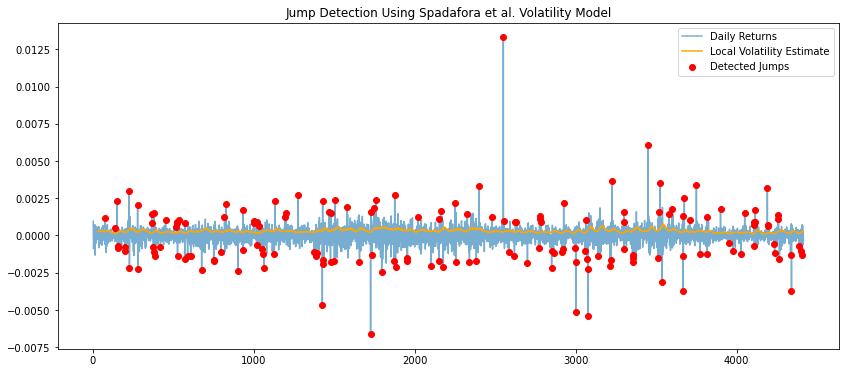

In [24]:
# Step 1: Estimate local volatility
local_vols = local_volatility_estimator(returns, window=30, exclude_top_n=2)

# Align returns to the jumps' index
aligned_returns = returns[local_vols.index]

# Select returns where jump is detected
jump_returns = aligned_returns[jumps == 1]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(returns.index, returns, label='Daily Returns', alpha=0.6)
plt.plot(local_vols.index, local_vols, label='Local Volatility Estimate', color='orange')
plt.scatter(jump_returns.index, jump_returns, color='red', label='Detected Jumps', zorder=5)
plt.legend()
plt.title("Jump Detection Using Spadafora et al. Volatility Model")
plt.show()
